In [50]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
import re

### Dataset

### Preparing the dataset
For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [15]:
df= pd.read_csv('housing.csv')
# keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df= df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [16]:
# Fill missing values with zeros.
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [17]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [18]:
# Apply the log transform to median_house_value.
df['median_house_value'] = np.log1p(df['median_house_value'])

In [19]:
# Do train/validation/test split with 60%/20%/20% distribution.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
# Use the train_test_split function and set the random_state parameter to 1.
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [20]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
features = ["longitude", "latitude", "housing_median_age", "total_rooms", 
            "total_bedrooms", "population", "households",
            "median_income", "ocean_proximity"]

train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

### Question 1
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?
- ocean_proximity
- total_rooms
- latitude
- population

In [23]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [26]:
export_text(dt, feature_names=dv.feature_names_)

'|--- ocean_proximity=INLAND <= 0.50\n|   |--- value: [2.59]\n|--- ocean_proximity=INLAND >  0.50\n|   |--- value: [2.53]\n'

### Question 2
Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?
- 0.045
- 0.245
- 0.545
- 0.845

In [28]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.01883416298423481

### Question 3
Now let's experiment with the n_estimators parameter
- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.
- 10
- 25
- 50
- 160

In [35]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

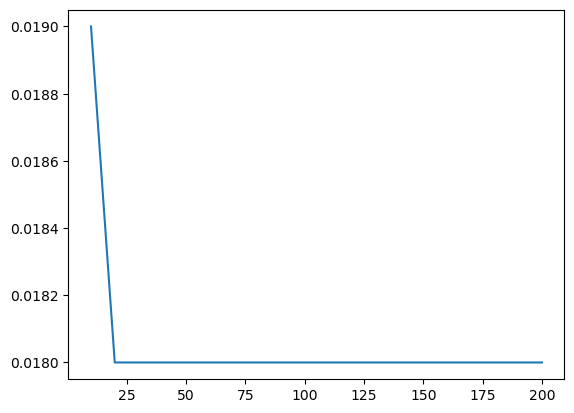

In [37]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

### Question 4
Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
  - try different values of n_estimators from 10 till 200 (with step 10)
  - calculate the mean RMSE
- Fix the random seed: random_state=1
    
What's the best max_depth, using the mean RMSE?
- 10
- 15
- 20
- 25

In [39]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, 
                               n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

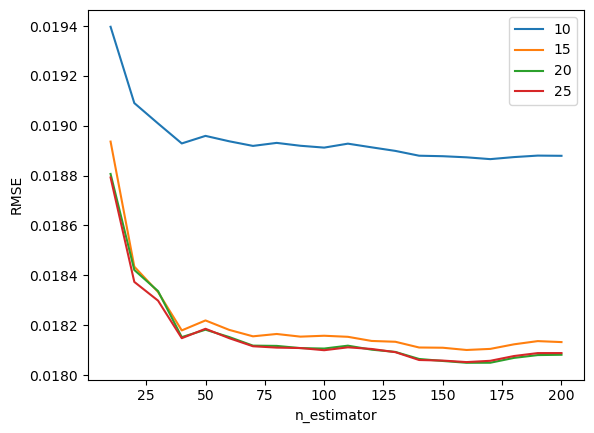

In [40]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.xlabel('n_estimator')
plt.ylabel('RMSE')
plt.show()

### Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:
- Train the model with these parameters:
   - n_estimators=10,
   - max_depth=20,
   - random_state=1,
   - n_jobs=-1 (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?
- total_rooms
- median_income
- total_bedrooms
- longitude

In [41]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20,
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [42]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances = df_importances.sort_values(by='importance', ascending=False)
df_importances

,feature,importance
4,median_income,0.331581
5,ocean_proximity=<1H OCEAN,0.222761
6,ocean_proximity=INLAND,0.146097
2,latitude,0.101455
3,longitude,0.086482
1,housing_median_age,0.030576
7,population,0.028101
9,total_rooms,0.021582
8,total_bedrooms,0.015851
0,households,0.015515


### Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?
- 0.3
- 0.1
- Both give equal value

In [51]:
features = dv.feature_names_

regex = re.compile(r"[<\s]", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=_1H_OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [52]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [53]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [54]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [55]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [56]:
scores['eta=0.3'] = parse_xgb_output(output)

In [57]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [58]:
scores['eta=0.1'] = parse_xgb_output(output)

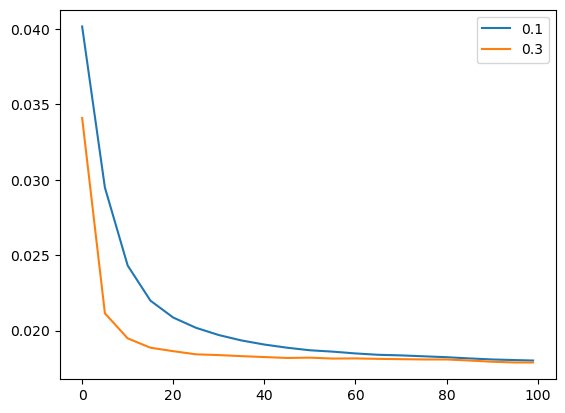

In [59]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()